In [4]:
!pip install opencv-python imutils

In [5]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [6]:
!kaggle datasets list


ref                                                        title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mosapabdelghany/medical-insurance-cost-dataset             Medical Insurance Cost Dataset                        16425  2025-08-24 11:54:36.533000          19323        387  1.0              
zadafiyabhrami/global-crocodile-species-dataset            Global Crocodile Species Dataset                      57473  2025-08-26 08:46:11.950000          12804        336  1.0              
codebynadiia/gdp-per-country-20202025                      GDP per Country 2020–2025                              5677  2025-09-04 14:37:43.563000          10113        190  1.0              
saadaliyaseen/analyzing-student-academic

In [7]:
!mkdir -p cancernet datasets/original datasets/idc

In [8]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip -d /content/datasets/original/


Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/datasets/original/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: 

In [9]:
import os
import random
import shutil
from imutils import paths

# Define paths
INPUT_DATASET = "/content/datasets/original"
BASE_PATH = "/content/datasets/idc"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH   = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH  = os.path.sep.join([BASE_PATH, "testing"])

# Split ratios
TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1

# Get all image paths
imagePaths = list(paths.list_images(INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

# Train/test split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# Train/val split
j = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:j]
trainPaths = trainPaths[j:]

datasets = [
    ("training", trainPaths, TRAIN_PATH),
    ("validation", valPaths, VAL_PATH),
    ("testing", testPaths, TEST_PATH),
]

# Build directory structure
for (setType, pathsList, basePath) in datasets:
    print(f"[INFO] Building {setType} set...")
    for imgPath in pathsList:
        # extract filename and label
        filename = imgPath.split(os.path.sep)[-1]
        label = filename[-5:-4]  # last digit before extension (0 or 1)

        # create label folder if not exists
        labelPath = os.path.sep.join([basePath, label])
        os.makedirs(labelPath, exist_ok=True)

        # copy file
        newPath = os.path.sep.join([labelPath, filename])
        shutil.copy2(imgPath, newPath)

print("[INFO] Dataset split complete!")


[INFO] Building training set...
[INFO] Building validation set...
[INFO] Building testing set...
[INFO] Dataset split complete!


In [10]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dropout, Dense, BatchNormalization
from keras.layers import SeparableConv2D, MaxPooling2D
from keras import backend as K

def build_cancernet(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    # First CONV block
    model.add(SeparableConv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second CONV block
    model.add(SeparableConv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(SeparableConv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third CONV block
    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(SeparableConv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


Found 255750 images belonging to 2 classes.
Found 42661 images belonging to 2 classes.
Found 99910 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[INFO] Training model...
Epoch 1/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 582s 71ms/step - accuracy: 0.8345 - loss: 0.4141 - val_accuracy: 0.7700 - val_loss: 0.4899
Epoch 2/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 417s 52ms/step - accuracy: 0.8572 - loss: 0.3370 - val_accuracy: 0.8469 - val_loss: 0.3824
Epoch 3/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 365s 46ms/step - accuracy: 0.8622 - loss: 0.3268 - val_accuracy: 0.8553 - val_loss: 0.3557
Epoch 4/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 368s 46ms/step - accuracy: 0.8646 - loss: 0.3217 - val_accuracy: 0.8435 - val_loss: 0.3765
Epoch 5/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 364s 46ms/step - accuracy: 0.8662 - loss: 0.3182 - val_accuracy: 0.8548 - val_loss: 0.3473
Epoch 6/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 362s 45ms/step - accuracy: 0.8678 - loss: 0.3137 - val_accuracy: 0.8624 - val_loss: 0.3294
Epoch 7/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 362s 45ms/step - accuracy: 0.8700 - loss: 0.3098 - val_accuracy: 0.8669 - val_loss: 0.3229
Epoch 8/20
7993/7993 ━━━━━━━━━━━━━━━━━━━━ 38

[INFO] Model saved as cancernet.h5
[INFO] Evaluating model...
3123/3123 ━━━━━━━━━━━━━━━━━━━━ 97s 30ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     71682
           1       0.76      0.80      0.78     28228

    accuracy                           0.87     99910
   macro avg       0.84      0.85      0.84     99910
weighted avg       0.87      0.87      0.87     99910

[INFO] Confusion Matrix:
[[64453  7229]
 [ 5720 22508]]


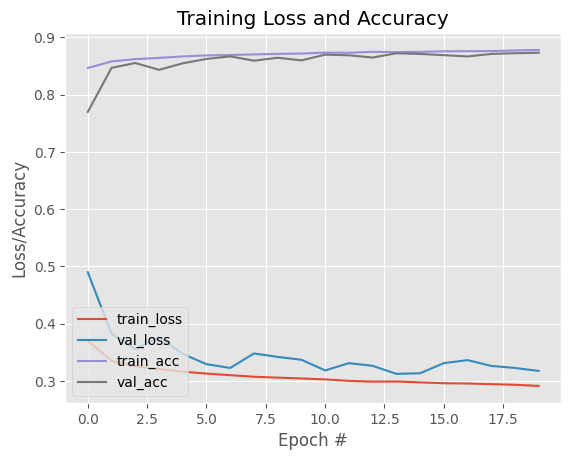

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adagrad
from sklearn.metrics import classification_report, confusion_matrix

# Paths
TRAIN_PATH = "/content/datasets/idc/training"
VAL_PATH   = "/content/datasets/idc/validation"
TEST_PATH  = "/content/datasets/idc/testing"

# Hyperparameters
NUM_EPOCHS = 20   # you can increase to 40 for better results
INIT_LR = 1e-2
BS = 32
IMG_SIZE = (48, 48)

# Data augmentation for training, simple rescaling for val/test
trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
valAug = ImageDataGenerator(rescale=1/255.0)

# Generators
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=True,
    batch_size=BS
)
valGen = valAug.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)
testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=False,
    batch_size=BS
)

# Build model
model = build_cancernet(width=48, height=48, depth=3, classes=2)

# Compile
opt = Adagrad(learning_rate=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train
print("[INFO] Training model...")
H = model.fit(
    trainGen,
    steps_per_epoch=len(trainGen),
    validation_data=valGen,
    validation_steps=len(valGen),
    epochs=NUM_EPOCHS
)

# Save model
model.save("cancernet.h5")
print("[INFO] Model saved as cancernet.h5")

# Evaluate
print("[INFO] Evaluating model...")
testGen.reset()
predIdxs = model.predict(testGen, steps=len(testGen))
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testGen.classes, predIdxs,
                            target_names=list(testGen.class_indices.keys())))

cm = confusion_matrix(testGen.classes, predIdxs)
print("[INFO] Confusion Matrix:")
print(cm)

# Plot training curves
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [15]:
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import files

# Upload an image (histopathology patch)
uploaded = files.upload()

# Load model
model = load_model("cancernet.h5")

for fname in uploaded.keys():
    # Load and preprocess image
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Prediction
    pred = model.predict(image)[0]
    label = "Cancer" if np.argmax(pred) == 1 else "No Cancer"

    print(f"Image: {fname} → Prediction: {label}")


Saving 10272_idx5_x1001_y1001_class0.png to 10272_idx5_x1001_y1001_class0.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: 10272_idx5_x1001_y1001_class0.png → Prediction: No Cancer


In [16]:
!pip freeze > requirements.txt
